# Assignment 4. Deep Learning

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For questions 1 refer to @alino_9 on Telegram. For questions 2-4 refer to @alregamo on Telegram.*

### Description  
This homework consists of four questions, each aimed at one category in the world of Deep Learning.   
1. Getting familiarized with sentiment analysis (A subject also covered in the course project).
   
2. Multi-layer perceptron (MLP). 
   
3. Convolutional Neural Networks (CNN).
   
4. Variational Autoencoders (VAE).

### Information  
Complete the information box below.

In [21]:
full_name = 'Ali Nikkhah'
student_id = '99102445'

### Note
The questions are not necessarily in order of difficulty. You are obligated to answer **3 out of 4** questions. The fourth question is optional and is considered as bonus.

## 4 Variation Autoencoder (VAE)

In this [link](https://lilianweng.github.io/posts/2018-08-12-vae/), you can find out more about autoencoders in general and a good explanation about variational autoencoders as well, known as VAEs.

In [61]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
import torch
from torchvision import datasets, transforms


torch.manual_seed(42)

The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing various image processing and machine learning models. It contains 60,000 training images and 10,000 testing images of size (28, 28) and their corresponding labels from 0 to 9.

### 4.1 Data Visualization

Show 3 random samples from the dataset.

*Hint: you can use "cv2" library for reading images but any other method is acceptable.*

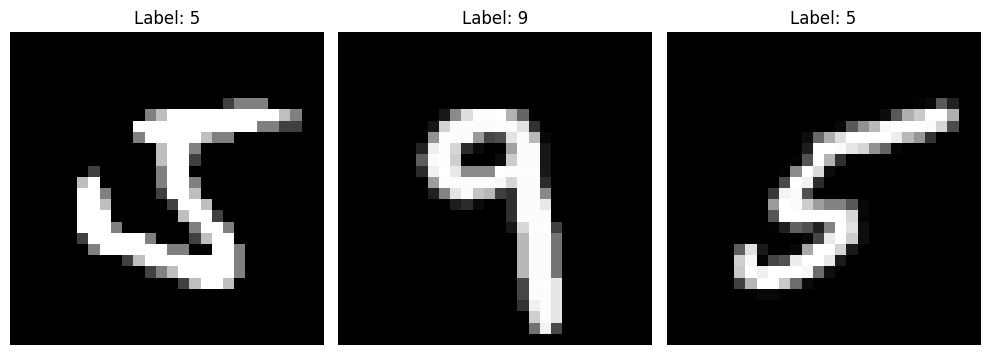

In [64]:
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

# Load the MNIST dataset without applying the Flatten transformation
transform = transforms.ToTensor()
data = datasets.MNIST('data', train=True, download=True, transform=transform)

# Show 3 random samples from the dataset
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i in range(3):
    index = random.randint(0, len(data))
    image, label = data[index]
    axes[i].imshow(image.squeeze().numpy(), cmap='gray')  # Convert tensor to NumPy array and display
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


This code defines a VAE class for a variational autoencoder (VAE) model, a generative model with an encoder-decoder based structure. The encoder compresses an input to a latent vector, which is drawn from a distribution learned by the encoder outputs. The decoder reconstructs the input from the latent vector, and the model optimizes the reconstruction quality and the difference between the latent distribution and a prior distribution. A VAE class usually specifies the encoder and decoder networks, the sampling layer, and the loss function.

### 4.2 Complete the following class to define the VAE structure.

In [70]:
from torchvision import datasets, transforms

class FlattenImage(object):
    def __call__(self, img):
        return img.view(-1)

# Define the transformation pipeline with the custom FlattenImage transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    FlattenImage()  # Flatten the 2D image to a 1D vector
])

# Load the MNIST dataset with the defined transformations
data = datasets.MNIST('data', train=True, download=True, transform=transform)


In [71]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_size, latent_size):
        super(VAE, self).__init__() 
        # Assign the dimensions of the hidden layer and the latent space
        self.hidden_dim = hidden_size
        self.latent_dim = latent_size
        # Define Encoder layers: map the input data to the mean and log variance of the latent space
        self.encoder_fc1 = nn.Linear(input_dim, hidden_size)
        self.encoder_fc2_mean = nn.Linear(hidden_size, latent_size)
        self.encoder_fc2_logvar = nn.Linear(hidden_size, latent_size)
        # Define Decoder layers: map the latent space to the reconstructed output data
        self.decoder_fc1 = nn.Linear(latent_size, hidden_size)
        self.decoder_fc2 = nn.Linear(hidden_size, input_dim)
    def encode(self, x):
        # Encode the input to the latent space using linear transformation layers and a ReLU activation function.
        x = F.relu(self.encoder_fc1(x))
        mean = self.encoder_fc2_mean(x)
        logvar = self.encoder_fc2_logvar(x)
        return mean, logvar
    
    def reparameterize(self, mu, logvar):
        # Reparameterize the mean and log variance and get a sample from the latent space using the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        '''
        Decode the latent space to the output space through linear transformations and activation functions.
        '''
        # Apply linear transformations and activations
        x = F.relu(self.decoder_fc1(z))
        x = torch.sigmoid(self.decoder_fc2(x))
        return x
    
    def forward(self, x):
        # The forward propagation of your model:
        # Encode the input data and get the mean and log variance of the latent space
        mu, logvar = self.encode(x)
        # Reparameterize the mean and log variance and get a sample from the latent space
        z = self.reparameterize(mu, logvar)
        # Return the decoded samples, mu, and logvar
        decoded = self.decode(z)
        return decoded, mu, logvar


### 4.3 Define the Loss Function
Compute the binary cross entropy between the reconstructed data and the original data.

Also, you need to compute the KL divergence between the distribution of the latent space and a standard normal distribution.

The total loss would be the sum of these two losses.

In [72]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    # Compute the binary cross entropy between the reconstructed data and the original data
    reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # Compute the KL divergence between the Gaussian distribution of the latent space and a standard normal distribution
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Return the sum of binary cross entropy and KL divergence as the total loss
    return reconstruction_loss + kl_divergence


### 4.4 Training the Model

Here we have provided a function which trains the model using the specified input arguments. (Make sure to understand the code!)

In [73]:
def train(model, optimizer, train_loader, epochs, device):
    model.train()
    train_loss = 0
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [76]:
from tqdm import tqdm

# Set the batch size for loading the data
batch_size = 128  # You can adjust this value as needed

# Create a data loader object that shuffles and batches the data
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Choose the device (CPU or GPU) based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the VAE model and move it to the device
model = VAE(hidden_size=256, latent_size=64, input_dim=28*28).to(device)  # Example hidden_size and latent_size values

# Create an instance of the Adam optimizer with a learning rate
learning_rate = 1e-3  # You can try different learning rates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50  # Set the number of epochs to train the model

# Train your VAE model with tqdm
for epoch in tqdm(range(epochs), desc='Training Epochs'):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, _) in enumerate(train_loader):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()
    
    # Calculate and display the average loss for each epoch
    average_loss = running_loss / len(train_loader)
    tqdm.write(f"Epoch [{epoch + 1}/{epochs}] - Loss: {average_loss:.4f}")


Training Epochs:   2%|▌                          | 1/50 [00:03<02:50,  3.49s/it]

Epoch [1/50] - Loss: 23138.3224


Training Epochs:   4%|█                          | 2/50 [00:06<02:47,  3.49s/it]

Epoch [2/50] - Loss: 17214.5212


Training Epochs:   6%|█▌                         | 3/50 [00:10<02:43,  3.49s/it]

Epoch [3/50] - Loss: 15757.7963


Training Epochs:   8%|██▏                        | 4/50 [00:13<02:39,  3.47s/it]

Epoch [4/50] - Loss: 14981.8089


Training Epochs:  10%|██▋                        | 5/50 [00:17<02:38,  3.53s/it]

Epoch [5/50] - Loss: 14542.3462


Training Epochs:  12%|███▏                       | 6/50 [00:21<02:34,  3.52s/it]

Epoch [6/50] - Loss: 14265.5513


Training Epochs:  14%|███▊                       | 7/50 [00:24<02:30,  3.51s/it]

Epoch [7/50] - Loss: 14090.4665


Training Epochs:  16%|████▎                      | 8/50 [00:27<02:26,  3.50s/it]

Epoch [8/50] - Loss: 13967.6586


Training Epochs:  18%|████▊                      | 9/50 [00:31<02:23,  3.49s/it]

Epoch [9/50] - Loss: 13886.3194


Training Epochs:  20%|█████▏                    | 10/50 [00:34<02:19,  3.49s/it]

Epoch [10/50] - Loss: 13811.2241


Training Epochs:  22%|█████▋                    | 11/50 [00:38<02:16,  3.49s/it]

Epoch [11/50] - Loss: 13761.9150


Training Epochs:  24%|██████▏                   | 12/50 [00:41<02:12,  3.48s/it]

Epoch [12/50] - Loss: 13714.3913


Training Epochs:  26%|██████▊                   | 13/50 [00:45<02:08,  3.48s/it]

Epoch [13/50] - Loss: 13670.5528


Training Epochs:  28%|███████▎                  | 14/50 [00:48<02:05,  3.48s/it]

Epoch [14/50] - Loss: 13635.9924


Training Epochs:  30%|███████▊                  | 15/50 [00:52<02:01,  3.48s/it]

Epoch [15/50] - Loss: 13604.9322


Training Epochs:  32%|████████▎                 | 16/50 [00:55<01:58,  3.48s/it]

Epoch [16/50] - Loss: 13577.4582


Training Epochs:  34%|████████▊                 | 17/50 [00:59<01:54,  3.47s/it]

Epoch [17/50] - Loss: 13555.4622


Training Epochs:  36%|█████████▎                | 18/50 [01:02<01:51,  3.47s/it]

Epoch [18/50] - Loss: 13542.0875


Training Epochs:  38%|█████████▉                | 19/50 [01:06<01:47,  3.47s/it]

Epoch [19/50] - Loss: 13517.3111


Training Epochs:  40%|██████████▍               | 20/50 [01:09<01:44,  3.48s/it]

Epoch [20/50] - Loss: 13495.6319


Training Epochs:  42%|██████████▉               | 21/50 [01:13<01:40,  3.48s/it]

Epoch [21/50] - Loss: 13477.7656


Training Epochs:  44%|███████████▍              | 22/50 [01:16<01:37,  3.49s/it]

Epoch [22/50] - Loss: 13462.6615


Training Epochs:  46%|███████████▉              | 23/50 [01:20<01:35,  3.52s/it]

Epoch [23/50] - Loss: 13451.3148


Training Epochs:  48%|████████████▍             | 24/50 [01:23<01:31,  3.52s/it]

Epoch [24/50] - Loss: 13437.8141


Training Epochs:  50%|█████████████             | 25/50 [01:27<01:27,  3.51s/it]

Epoch [25/50] - Loss: 13429.5176


Training Epochs:  52%|█████████████▌            | 26/50 [01:30<01:23,  3.50s/it]

Epoch [26/50] - Loss: 13421.2396


Training Epochs:  54%|██████████████            | 27/50 [01:34<01:20,  3.50s/it]

Epoch [27/50] - Loss: 13404.7359


Training Epochs:  56%|██████████████▌           | 28/50 [01:37<01:16,  3.49s/it]

Epoch [28/50] - Loss: 13396.0508


Training Epochs:  58%|███████████████           | 29/50 [01:41<01:13,  3.48s/it]

Epoch [29/50] - Loss: 13386.3354


Training Epochs:  60%|███████████████▌          | 30/50 [01:44<01:09,  3.48s/it]

Epoch [30/50] - Loss: 13375.9533


Training Epochs:  62%|████████████████          | 31/50 [01:48<01:05,  3.47s/it]

Epoch [31/50] - Loss: 13360.6359


Training Epochs:  64%|████████████████▋         | 32/50 [01:51<01:02,  3.46s/it]

Epoch [32/50] - Loss: 13357.9592


Training Epochs:  66%|█████████████████▏        | 33/50 [01:55<00:58,  3.46s/it]

Epoch [33/50] - Loss: 13343.4428


Training Epochs:  68%|█████████████████▋        | 34/50 [01:58<00:55,  3.46s/it]

Epoch [34/50] - Loss: 13341.8875


Training Epochs:  70%|██████████████████▏       | 35/50 [02:01<00:51,  3.46s/it]

Epoch [35/50] - Loss: 13333.5843


Training Epochs:  72%|██████████████████▋       | 36/50 [02:05<00:48,  3.46s/it]

Epoch [36/50] - Loss: 13334.1999


Training Epochs:  74%|███████████████████▏      | 37/50 [02:08<00:45,  3.47s/it]

Epoch [37/50] - Loss: 13317.2472


Training Epochs:  76%|███████████████████▊      | 38/50 [02:12<00:41,  3.46s/it]

Epoch [38/50] - Loss: 13305.4456


Training Epochs:  78%|████████████████████▎     | 39/50 [02:15<00:38,  3.46s/it]

Epoch [39/50] - Loss: 13303.5555


Training Epochs:  80%|████████████████████▊     | 40/50 [02:19<00:34,  3.47s/it]

Epoch [40/50] - Loss: 13296.5834


Training Epochs:  82%|█████████████████████▎    | 41/50 [02:22<00:31,  3.46s/it]

Epoch [41/50] - Loss: 13290.2342


Training Epochs:  84%|█████████████████████▊    | 42/50 [02:26<00:27,  3.46s/it]

Epoch [42/50] - Loss: 13286.9002


Training Epochs:  86%|██████████████████████▎   | 43/50 [02:29<00:24,  3.46s/it]

Epoch [43/50] - Loss: 13278.9825


Training Epochs:  88%|██████████████████████▉   | 44/50 [02:33<00:20,  3.46s/it]

Epoch [44/50] - Loss: 13275.5938


Training Epochs:  90%|███████████████████████▍  | 45/50 [02:36<00:17,  3.46s/it]

Epoch [45/50] - Loss: 13269.5223


Training Epochs:  92%|███████████████████████▉  | 46/50 [02:40<00:13,  3.47s/it]

Epoch [46/50] - Loss: 13261.5894


Training Epochs:  94%|████████████████████████▍ | 47/50 [02:43<00:10,  3.47s/it]

Epoch [47/50] - Loss: 13253.5946


Training Epochs:  96%|████████████████████████▉ | 48/50 [02:46<00:06,  3.46s/it]

Epoch [48/50] - Loss: 13249.8968


Training Epochs:  98%|█████████████████████████▍| 49/50 [02:50<00:03,  3.46s/it]

Epoch [49/50] - Loss: 13240.9130


Training Epochs: 100%|██████████████████████████| 50/50 [02:53<00:00,  3.48s/it]

Epoch [50/50] - Loss: 13247.9691


### 4.5 Generative Model
Now that you have trained your model, you can generate new images by sampling from the latent space and decoding them as below: (make sure to understand how the code works!)

torch.Size([128, 784])


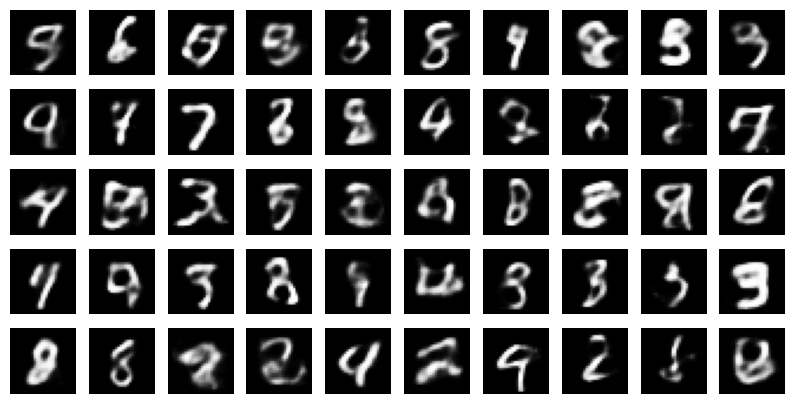

In [77]:
with torch.no_grad():
    # Generate random samples from the latent space matching the model's latent_size
    z = torch.randn(batch_size, model.latent_dim).to(device)
    sample = model.decode(z).cpu()
    print(sample.size())

    # Plot the generated images
    fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))
    for i in range(5):
        for j in range(10):
            ax[i][j].imshow(sample[i * 10 + j].reshape(28, 28), cmap='gray')
            ax[i][j].axis('off')
    plt.show()


